# Receiver Operator Characteristic (ROC) Analysis - 
# Balanced Random Forest Classifier

## 1. ETL for ROC curve analysis

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from imblearn.metrics import classification_report_imbalanced
from scipy import stats
import seaborn as sns

In [4]:
# Bringing in our model(s) to compare to the APACHE II results

In [5]:
df_patient = pd.read_csv("database_patient.csv")
df_patient.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,icu_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68,22.73,0,2,1,1,...,0,0,1,0,0,0,0,0,9,0
1,114252,59342,81,0,77,27.42,0,2,0,1,...,0,0,1,0,0,0,0,0,8,6
2,119783,50777,118,0,25,31.95,0,2,0,0,...,0,0,0,0,0,0,0,0,5,3
3,79267,46918,118,0,81,22.64,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
4,33181,74489,83,0,67,27.56,0,2,1,0,...,0,0,1,0,0,0,0,0,7,4


In [6]:
# Creating our features
X = df_patient.drop('hospital_death', axis=1)
X.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_id,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,68,22.73,0,2,1,1,92,...,0,0,1,0,0,0,0,0,9,0
1,114252,59342,81,77,27.42,0,2,0,1,90,...,0,0,1,0,0,0,0,0,8,6
2,119783,50777,118,25,31.95,0,2,0,0,93,...,0,0,0,0,0,0,0,0,5,3
3,79267,46918,118,81,22.64,1,2,0,2,92,...,0,0,0,0,0,0,0,0,0,0
4,33181,74489,83,67,27.56,0,2,1,0,95,...,0,0,1,0,0,0,0,0,7,4


In [7]:
X.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_id,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
count,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,...,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000,73262.000000
mean,65654.462341,65551.914512,106.463992,62.371038,29.317898,0.184134,2.035080,0.543706,0.689157,516.566078,...,0.000942,0.016543,0.229068,0.013827,0.027722,0.007480,0.004081,0.021662,4.378600,2.592640
std,37769.374703,37792.056466,63.245110,16.764922,8.292887,0.387596,1.067173,0.498227,0.939700,223.889032,...,0.030675,0.127554,0.420236,0.116774,0.164178,0.086164,0.063755,0.145578,3.827921,2.839358
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,0.000000,0.000000,0.000000,82.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32879.250000,32841.500000,49.000000,52.000000,23.739453,0.000000,2.000000,0.000000,0.000000,376.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65844.500000,65466.000000,112.000000,65.000000,27.812500,0.000000,2.000000,1.000000,0.000000,504.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000
75%,98326.750000,98282.750000,166.000000,75.000000,33.091592,0.000000,2.000000,1.000000,1.000000,684.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000
max,131051.000000,131051.000000,204.000000,89.000000,67.814990,1.000000,6.000000,2.000000,5.000000,927.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,10.000000


In [8]:
# Creating our target
y = df_patient['hospital_death']
y.value_counts()

0    67400
1     5862
Name: hospital_death, dtype: int64

In [9]:
# Splitting data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [10]:
# Checking balances
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 50550, 1: 4396})
Counter({0: 16850, 1: 1466})


In [11]:
# Resampling the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiating
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fitting
brfc.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

## 2. ROC Curve Plotting and AUC Calculation

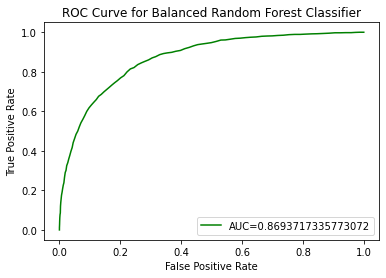

In [17]:
# Defining metrics
y_pred_proba = brfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Creating ROC curve
plt.plot(fpr,tpr, color='green',label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Balanced Random Forest Classifier')
plt.legend(loc=4)
plt.show()